# DDN with Learnable parameters

In this tutorial, we extends DDN Robust Pooling to the training of $\alpha$ parameter, recall from the paper, authors computed the gradient of robust pooling respect to input x. The $\alpha$ parameter is fixed during proprogation, thus there is no need compute the gradient respect to parameter $\alpha$. Now we relax this restriction, include $\alpha$ as a trainable parameter and compute its derivate.

In general,the compuation of $Dy(\alpha)$ is the same as $Dy(x)$: pervious we compute $D^2_{XY}f(x,y), D^2_{YY}f(x,y), D_{X}h(x,y) , D^2_{XY}h(x,y), D^2_{YY}f(x,y)$, now we change every x to $\alpha$: That is $D^2_{\alpha Y}f(\alpha,y), D^2_{YY}f\alpha,y), D_{\alpha}h(\alpha,y) , D^2_{\alpha Y}h(\alpha,y), D^2_{YY}f(\alpha,y). $ Note we write $f(\alpha,x,y )$ as $f(\alpha ,y)$ because x can be treated as a constant for $Dy(\alpha)$.

## Closed-form Gradient  for robust pooling
In this section we compute the closed-form gradient of 4 different robust pooling function: peseudo-huber, huber, welsch and truncated quadratic.

Recall the gradient for unconstrained function: $D(y(\alpha)) = -H^{-1}B$ where $H= D^2_{YY}f(\alpha, y)$ and $B= D^2_{\alpha Y} f(\alpha,y) $

### Pseudo- Huber

$y \in  \text{argmin}_y  \sum_i^n \alpha^2 (\sqrt {1+ \frac {(y-x_i)^2} {\alpha^2}}-1)$


$Dy(\alpha) = -\sum_{i=1}^N \sum_{j=1}^N((\frac {y-x_i} {\alpha})^2 + 1)^{\frac{3}{2}}(\frac {(y-x_j)^3} {((\frac {y-x_j} {\alpha})^2 + 1)^{\frac{3}{2}}\alpha^3})$

###  Huber

$y \in \text{argmin}_y \sum_{i=1}^N $ $\begin{cases} 
\frac {1} {2} (y-x_i)^2 & \text{$ |y-x_i| \leq \alpha $} \\
\alpha(|y-x_i|-\frac {1} {2} \alpha) & \text{otherwise}\\
\end{cases}$

$Dy(\alpha) = \sum_{i=1}^N $ $\begin{cases} 
0 & \text{$ |y-x_i| \leq \alpha $} \\
1 & \text{$ y - x_i > \alpha $}\\
-1 & \text{$ y - x_i < \alpha $}
\end{cases}$

### Welsch

$y \in  \text{argmin}_y  \sum_{i=1}^n (1-exp(- \frac {(y-x_i)^2} {2\alpha^2}))$

$Dy(\alpha) = \sum_{i=1}^N (- \frac {e^{-\frac {(y-x_i)^2} {2 \alpha^2}} (2 (y-x_i) \alpha^2 - (y-x_i)^3)} {\alpha^5}) $

### Truncated Quadatic

$y \in \text{argmin}_y \sum_{i=1}^N $ $\begin{cases} 
\frac {1} {2} (y-x_i)^2 & \text{$ |y-x_i| \leq \alpha $} \\
\frac {1} {2} \alpha^2 & \text{otherwise}\\
\end{cases}$

$Dy(\alpha) = 0$

###  Implementation

Below is the implmentation of $Dy(\alpha)$, I adapted some previous code from DDN repository.

In [1]:
import matplotlib.pyplot as plt
import autograd.numpy as np
import scipy.optimize as opt
import scipy as sci
import random
import matplotlib.pyplot as plt
from autograd import grad, jacobian
import sys
import torch
sys.path.append("../")
from ddn.basic.learnable_robust_nodes import LearnableRobustAverage
from ddn.basic.learnable_robust_nodes_new import LearnableRobustAverageNew
from ddn.basic.robust_nodes import RobustAverage
#from ddn.pytorch.learnable_projections import *

In [2]:
def dyalpha_closed_form(x,y,alpha,p='pseudo-huber'):
    alpha_sq=alpha**2
    if p=='pseudo-huber':
        dyy = np.array([np.power(1.0 + np.power(y - xi, 2.0) / alpha_sq, -1.5) for xi in x])
        dytheta =  np.sum([np.power(y-xi,3)/(np.power(np.power((y-xi)/alpha,2)+1,1.5)*np.power(alpha,3)) for xi in x])
    elif p=='huber':
        dyy = np.array([1.0 if np.abs(y - xi) <= alpha else 0.0 for xi in x])
        dytheta = np.sum(np.array([0.0 if np.abs(y - xi) <= alpha else (1.0 if y-xi>0 else -1.0) for xi in x]))
    elif p=='welsch':
        z = np.power(x - y, 2.0)
        dyy = np.array([(alpha_sq - zi) / (alpha_sq * alpha_sq) * np.exp(-0.5 * zi / alpha_sq) for zi in z])
        dytheta=np.sum(np.array([-np.exp(-0.5 * np.power((y - xi)/alpha,2))*((2*(y-xi)*alpha_sq-np.power(y-xi,3))/(alpha**5)) for xi in x])) 
    elif p=='trunc-quad':
        return 0
    return -1.0 * dytheta/np.sum(dyy)

We can also compute the gradient using pytorch autograd libray

In [3]:
def dyalpha(x,y,alpha,p='pseudo-huber'):
    fY = grad(f, 1)
    #print("fy",fY(x, y, alpha,p))
    fYY = jacobian(fY, 1)
    fthetaY = jacobian(fY, 2)
    return -1.0 * np.linalg.pinv(fYY(x, y, alpha,p)).dot(fthetaY(x, y, alpha,p))

We can check the correctness of closed form graident by comparing it with autograd gradient

In [4]:
# the objective function from ddn.basic.node
def f(x, y, alpha,p='pseudo-huber'):
    alpha_sq=alpha**2
    if p=='pseudo-huber':
        phi= lambda z: (alpha**2) * (np.sqrt(1.0 + np.power(z, 2.0) / (alpha**2)) - 1.0)
    elif p=='huber':
        phi = lambda z: np.where(np.abs(z) <= alpha, 0.5 * np.power(z, 2.0), alpha * np.abs(z) - 0.5 * alpha_sq)
    elif p=='welsch':
        phi = lambda z: 1.0 - np.exp(-0.5 * np.power(z, 2.0) / alpha_sq)
    elif p=='trunc-quad':
        phi = lambda z: np.minimum(0.5 * np.power(z, 2.0), 0.5 * alpha_sq)
    return np.sum([phi(y - xi) for xi in x])

# the solve objective function from ddn.basic.node
def solve(x,alpha ,f, p='pseudo-huber'):
    result = opt.minimize(lambda y : f(x, y, alpha,p), np.mean(x))
    return result.x

In [5]:

n = 10 # number of input points
y_target = np.array([0.0])
x_init = np.random.rand(n)
# add an outlier
x_init[np.random.randint(len(x_init))] += 100.0 * np.random.rand(1)
x_init=np.array([ 1.4748, -0.0034,  2.1072, -0.0675, -0.7821, -0.9080, -2.0427,
          -1.9460,  1.7862,  0.1601])
alpha_init = random.uniform(0.1, 10)

In [6]:
print('x:',x_init)
print('alpha:',alpha_init)
print(np.array([np.mean(x_init)]))
print(f(x_init,np.array([np.mean(x_init)]),1.0))
print(dyalpha(x_init,np.array([np.mean(x_init)]),alpha_init,'pseudo-huber'))
print(dyalpha_closed_form(x_init,np.array([np.mean(x_init)]),alpha_init,'pseudo-huber'))
# valid the analyic gradient is the same as autograd solution
#print("error between autograd and closed-form:")
#y_init = solve(x_init,alpha_init,f,'pseudo-huber')
#print("pseudo-huber ",abs(dyalpha_closed_form(x_init,y_init,alpha_init,'pseudo-huber')-dyalpha(x_init,y_init,alpha_init,'pseudo-huber')))
#y_init = solve(x_init,alpha_init,f,'huber')
#print("huber ",abs(dyalpha_closed_form(x_init,y_init,alpha_init,'huber')-dyalpha(x_init,y_init,alpha_init,'huber')))
#y_init = solve(x_init,alpha_init,f,'welsch')
#print("welsch ",abs(dyalpha_closed_form(x_init,y_init,alpha_init,'welsch')-dyalpha(x_init,y_init,alpha_init,'welsch')))
#y_init = solve(x_init,alpha_init,f,'trunc-quad')
#print("trunc-quad",abs(dyalpha_closed_form(x_init,y_init,alpha_init,'trunc-quad')-dyalpha(x_init,y_init,alpha_init,'trunc-quad')))

x: [ 1.4748 -0.0034  2.1072 -0.0675 -0.7821 -0.908  -2.0427 -1.946   1.7862
  0.1601]
alpha: 3.323251798608022
[-0.02214]
6.251444836489072
[0.00510681]
0.005106805731382436


## Closed-form Gradient  for ball projection
Similar to robust pooling, we can compute the gradient respect to ball projection. 

Recall the gradient for equal constrained function:

$$
\begin{array}{lll}
    &Dy(r) = (H^{-1} A^T(AH^{-1}A^T)^{-1}AH^{-1}B-C)-H^{-1}B\\
    &A = D_Y h(x,y, r)\\
    &B = D^2_{rY} f(x,y, r) - \sum_{i=1}^pD^2_{rY} h_i(x,y, r)\\
    &C= D_r h(x,y, r)\\
    &H= D^2_{YY} f(x,y, r) - \sum_{i=1}^pD^2_{YY} h_i(x,y, r)\\
\end{array}
$$

The ball projection problem in general is defined:

\begin{array}{lll}
    y \in & \text{argmin}_u & \frac{1}{2} \|u - x\|^2_2 \\
    & \text{subject to} & \|x\|_p = r \\
\end{array}

### 1. analyical gradient using DDN theorm with equality constraint.
### L2 norm:

$$
\begin{array}{lll}
    y \in & \text{argmin}_u & \frac{1}{2} \|u - x\|^2 \\
    & \text{subject to} & u_1^2 + u_2^2 - r^2 = 0 \\
    & & 
\end{array}
\begin{array}{lll}
    y \in & \text{argmin}_u & \frac{1}{2} \|u - x\|^2 \\
    & \text{subject to} & u_1^2 + u_2^2 - r^2 = 0 \\
    & & 
\end{array}
$$
#### (a) analyical gradient using DDN theorm with equality constraint.
$$
\begin{array}{llll}
    A = \text{D}_{Y} h(r,y) &= 2 u^T \\
    B = \text{D}^2_{rY} f(r, y) - \sum_{i=1}^{3} \lambda_i \text{D}^2_{rY} h_i(r,y) &=0 \\
    C = \text{D}_{Y} h(r,y) &= -2r\\
    2u^T \lambda= u^T -x^T \Rightarrow \lambda= \sqrt{\frac {(u^T-x^T)(u-x)} {4^T}}\\ 
    H = \text{D}^2_{YY} f(r, y) - \sum_{i=1}^{3} \lambda_i \text{D}^2_{YY} h_i(r,y) &= (1 - 2 \lambda_1) I \\
    Dy(r) =  r \cdot \frac {y} {y^T y}
\end{array}
$$
#### (b)analyical gradient of closed form
$$
\begin{array}{lll}
    y(x,r) = \frac {r} {\| x\|_2} x\\
    Dy(r) = \frac {1} {\| x\|_2} x\\
\end{array}
$$
#### (c)gradient using DDN theorm with autograd.
$$
\begin{array}{lll}
    Dy(r) = (H^{-1} A^T(AH^{-1}A^T)^{-1}AH^{-1}B-C)-H^{-1}B
\end{array}
$$
### L1 norm:

\begin{array}{lll}
    y \in & \text{argmin}_u & \frac{1}{2} \|u - x\|^2 \\
    & \text{subject to} & \sum_i |x_i|  - r = 0 \\
    & & 
\end{array}

### Ln norm:


\begin{array}{lll}
    y \in & \text{argmin}_u & \frac{1}{2} \|u - x\|^2 \\
    & \text{subject to} & \max_i |x_i|  - r = 0 \\
    & & 
\end{array}

After Calculation, it turns out, for L1 and Ln norm:
\begin{array}{lll}
   B=0 \\
   H= I\\
   C=-1 \\
   Dy(r) = \frac {a^T} {\| a\|_2^2}\\ 
   a= D_y h(r,y)
\end{array}

The only difference is they have different $a$: 

For L1 norm, $a=vec\{indictor(i \in I^*) sign(y_i)\}$

For Ln norm, $a=vec\{(y_i)\}$

Below is the implmentation of $Dy(r)$, I adapted some previous code from DDN repository.

In [7]:
# objective 
def f(r,y,x):
    return 0.5* np.dot(y-x,y-x)

# constraint
def h(r,y,norm):
    if norm=='L1':
       # print(np.linalg.norm(y, 1)- np.sum(np.abs(y)))
        return np.sum(np.abs(y))-r
    if norm=='Ln':
        # print(np.max(np.abs(y))-np.linalg.norm(y, np.inf))
        return np.max(np.abs(y)) - r
    elif norm=='L2':
        return np.dot(y,y) - r**2
# forward solve
def solve_opt(x,r,f,norm):
    result = opt.minimize(lambda y: f(r, y ,x), np.ones(np.shape(x)[0]),constraints=[{'type':'eq', 'fun': lambda y: h(r,y,norm)}] )
    return result.x

# forward solve (L2 norm only)
def solve_analyical(x,r):
    return r / np.sqrt(np.dot(x, x)) * x

The gradient for L2, L1 and Ln. For L2 we write down the gradient with closed form for check. We write the gradient by autograd for check too.

In [8]:
def gradient_closed_form_L2(r,x):
    return 1 / np.sqrt(np.dot(x, x)) * x

def gradient_L2(r,x):
    y = solve_analyical(x,r)
    # a = 2*y
    # B = np.zeros(2)
    # C = -2*r
    # nu = np.sqrt(np.sum((y-x)**2)/(4*np.sum(y**2)))
    # H =(1-2*nu) *np.eye(2)
    return r*y/(np.sum(y*y))

def gradient_L1(r,x):
    y= solve_opt(x,r,f,'L1')
    a = np.sign(y)
    #nu= (y-x)[0]*a[0]
    #B = np.zeros(2)- nu*np.zeros(2)
    #C = -1.0
    #H = np.eye(2)-nu*np.zeros(2)
    return a/(a@a)

def gradient_Ln(r,x):
    y= solve_opt(x,r,f,'Ln')
    print('y:',y)
    y=np.round(y,4)
    print('y:',y)
    a = np.array([0 if np.abs(yi)<np.max(np.abs(y)) else np.sign(yi) for yi in y])
    #idx= np.where(y==y[np.abs(y)>=np.max(np.abs(y))])
    #nu=np.sign(y)[idx]* (y-x)[idx]
    #B= np.zeros(2)- nu*np.zeros(2)
    #C= -1.0
    print('a',a)
    #H = np.eye(2)-nu*np.zeros(2)
    print(a/(a@a))
    return a/(a@a)

def gradient_by_auto_diff(r,x,norm):
    fY = grad(f, 1)
    hY = grad(h,1)
    hR = grad(h,0)
    frY = jacobian(fY, 0)
    fYY = jacobian(fY, 1)
    hYY = jacobian(hY, 1)
    hrY= jacobian(hY, 0)
    y= solve_opt(x,r,f,norm)
    #y=solve_analyical(x,r)
    # print(y-solve_analyical(x,r))
    indx = np.nonzero(hY(r, y,norm))
    if len(indx[0]) == 0:
        nu= 0.0
    nu = fY(r, y, x)[indx[0][0]] / hY(r, y, norm)[indx[0][0]]
    H = fYY(r, y, x) - nu * hYY(r, y, norm)
    a = hY(r, y, norm)
    B = frY(r, y, x) - nu * hrY(r, y, norm)
    C = hR(r, y, norm)
    con = np.stack((a, B), axis=1)
    try:
        v = sci.linalg.solve(H, con, assume_a='pos')
    except:
         return np.full((2, 1), np.nan).squeeze()
    #print(nu,fYY(r, y, x),hYY(r, y, norm))
    return (np.outer(v[:, 0], (v[:, 0].dot(B) - C) / v[:, 0].dot(a)) - v[:, 1:1 + 1]).squeeze()

Random generate x and r, check error between the gradient computed by different form.

In [9]:
x= np.array([-1.2419,  1.1800, -0.7854, -0.7418])
#r= random.uniform(0.1, 10)
r=np.array(0.6128)
print('x:',x)
print('r:',r)
print("error:")
print("L2 closed form and L2 analytical DDN: ", abs(np.sum(gradient_L2(r,x)-gradient_closed_form_L2(r,x) )))
print("L2 analytical DDN and L2 autograd: ", abs(np.sum(gradient_L2(r,x)-gradient_by_auto_diff(r,x,'L2') )))
print("L1 analytical DDN and L1 autograd: ", abs(np.sum(gradient_L1(r,x)-gradient_by_auto_diff(r,x,'L1') )))
print("Ln analytical DDN and Ln autograd: ", abs(np.sum(gradient_Ln(r,x)-gradient_by_auto_diff(r,x,'Ln') )))
#node= L1Sphere()
#obj,_= node.project(torch.as_tensor(x), torch.as_tensor(r))
#print("L1 analytical DDN and Ln prtorch: ", node.gradient(torch.tensor([1]),obj,torch.tensor(x))[1]-np.sum(gradient_L1(r,x)))
#node= LInfSphere()
#obj,_= node.project(torch.as_tensor(x), torch.as_tensor(r))
#print("Ln analytical DDN and Ln pytorch: ", node.gradient(torch.tensor([1]),obj,torch.tensor(x))[1]-np.sum(gradient_Ln(r,x)))

x: [-1.2419  1.18   -0.7854 -0.7418]
r: 0.6128
error:
L2 closed form and L2 analytical DDN:  1.6653345369377348e-16
L2 analytical DDN and L2 autograd:  1.2798437478145352e-06
L1 analytical DDN and L1 autograd:  0.0
y: [-0.61279767  0.61279734 -0.61279827 -0.6128    ]
y: [-0.6128  0.6128 -0.6128 -0.6128]
a [-1.  1. -1. -1.]
[-0.25  0.25 -0.25 -0.25]
Ln analytical DDN and Ln autograd:  0.5


/students/u6361796/.conda/envs/myconda/lib/python3.7/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


## Learnable parameter on a bi-level optimisation problem
We can test the DDN with learnable parameter on bi-level optimisation problem. We use sum of squared error as the upper level loss function

$$
\begin{array}{ll}
    \text{minimize}_x & \frac{1}{2} \|y - y^\text{target}\|^2 \\
    \text{subject to} & y \in \left\{ \begin{array}{ll}
        \text{argmin}_u & f(x, u)\\
        \text{subject to} & h(x, u) = 0
        \end{array} \right\}
\end{array}
$$

We will use Simple Gradient and LFBGS mathod to backpropogate and learn the parameter.  I adapted two methods from previous tutorials.

In [37]:
def lbfgs(node, y_target, max_iters=1000,x_init=None, theta_init=None, verbose=True, train_x=False):
    """
    Example of using scipy.optimize to solve the problem via L-BFGS.
    """
    theta_start = theta_init if theta_init is not None else 1.0
    x_start = (x_init.clone() if type(x_init)==torch.Tensor else x_init.copy()) if x_init is not None else 1.0
    if train_x:
        para= torch.cat((x_start,torch.tensor([theta_start]))) if type(x_start)==torch.tensor else np.concatenate((x_start, np.array([theta_start])), axis=0)
    else:
        para= theta_start
    def J(para):
        if train_x:
            x= para[:-1]
            theta=para[-1]
        else:
            x=x_init
            theta=para
        if type(node)==LearnableRobustAverageNew:
            y, _ = node.solve(x, theta)
            return 0.5 * np.sum(np.square(y - y_target))
        else:
            x=torch.tensor(x)
            theta=torch.tensor(theta)
            y, _ = node.project(x, theta)
            return  0.5 * ((y - y_target)**2).sum()
    def dJdtheta(para):
        if train_x:
            x= para[:-1]
            theta=para[-1]
        else:
            x=x_init
            theta=para
        if type(node)==LearnableRobustAverageNew:
            y, _ = node.solve(x, theta)
            dx,dr= node.gradient(x, y, theta)
            DJdx=np.dot(y - y_target,dx).reshape((node.dim_x,))
            DJdr=(y - y_target)*dr
            if train_x:
                return np.concatenate((DJdx,DJdr),axis=0)
            else:
                return DJdr
        else:
            x=torch.tensor(x)
            theta=torch.tensor(theta)
            y, is_outside = node.project(x, theta)
            DJdx, DJdtheta = node.gradient((y - y_target),x, y,is_outside)
            if train_x:
                return torch.cat((DJdx,torch.tensor([DJdtheta])))
            else:
                return torch.tensor([DJdtheta])
    history = [J(para)]
    thetas=[theta_start]
    if type(node)==LearnableRobustAverageNew:
        ys=[node.solve(x_start, theta_start)]
    else:
        ys=[node.project(x_start, theta_start)]
    def callback(para):
        if train_x:
            x= para[:-1]
            theta=para[-1]
        else:
            x=x_init
            theta=para
        thetas.append(theta)
        history.append(J(para))
        if type(node)==LearnableRobustAverageNew:
            ys.append(node.solve(x, theta))
        else:
            x=torch.tensor(x)
            theta=torch.tensor(theta)
            ys.append(node.project(x, theta))
    opts = {'maxiter': max_iters, 'disp': verbose}
    result = opt.minimize(J, para, args=(), method='L-BFGS-B', jac=dJdtheta, options=opts, callback=callback)
    if train_x:
        x_final= result.x[:-1]
        theta_final= result.x[-1]
        if type(node)!=LearnableRobustAverageNew:
            x_final=torch.tensor(x_final)
            theta_final=torch.tensor([theta_final])
    else:
        x_final =x_init
        theta_final= result.x
    return theta_final, history,thetas,ys,x_final


def simpleGradientDescent(node, y_target, step_size=1.0e-3, tol=1.0e-6, max_iters=10000,x_init = None, theta_init=None, verbose=False,train_x=False):
    theta = theta_init if theta_init is not None else 0
    if type(node)==LearnableRobustAverageNew:
        x = x_init.copy()
        J = lambda y : 0.5 * np.sum(np.square(y - y_target))
    else:
        x = x_init.clone()
        J = lambda y : 0.5 * ((y - y_target)**2).sum()
    dJdy = lambda y : y - y_target
    history = []
    thetas=[]
    ys=[]
    for i in range(max_iters):
        # solve the lower-level problem and compute the upper-level objective
        if type(node)==LearnableRobustAverageNew:
            y, _ = node.solve(x,theta)
        else:
            y, is_outside = node.project(x,theta)
        history.append(J(y))
        if verbose: print("{:5d}: {}".format(i, history[-1]))
#         if (len(history) > 2) and (history[-2] - history[-1]) < tol:
#             break
        # compute the gradient of the upper-level objective with respect to x via the chain rule
        if type(node)==LearnableRobustAverageNew:
            dydx,dydtheta= node.gradient(x, y,theta)
            dJdx = np.dot(dJdy(y), dydx)
            dJdtheta = np.dot(dJdy(y), dydtheta)
        else:
            dJdx,dJdtheta = node.gradient(dJdy(y),x,y,is_outside)
        # take a step in the negative gradient direction
        theta -= step_size * dJdtheta
        if train_x:
            x -= step_size * dJdx
        if type(node)==LearnableRobustAverageNew:
            thetas.append(theta.copy())
        else:
            thetas.append(theta.clone())
        ys.append(y)
    return theta, history,thetas,ys,x

### Set input x fix, learn parameters

We first observe the converage of parameters($\alpha$ and $r$) while setting the input x fixed: We generate target and init y with same x but different parameters. We generate all this data randomly.

<span style="color:red">Sometimes it is possible that $\alpha,r$ run into negative, in this case the program will stop running as it is infeasible now, I am still trying to fix the bug in this situation.</span> 
### Set input x fix, learn parameters
By set train_x= True, we can learnable both x and parameter at the same time. 
#### On robust pooling:

In [38]:
np.random.seed(1123)
x_init=np.random.rand(50)
idx= np.random.choice(50, 5)
x_true=x_init.copy()
x_init[idx] += x_init[idx]+1

train_x=False
# #train_x=True

# if train_x:
#     x_true=np.random.rand(5)
#     x_true[np.random.randint(len(x_true))] += 100.0 * np.random.rand(1)
# else:
#     x_true=x_init.copy()
    
alpha_init=2.0


p='huber'
#p='Huber'
#p='welsch'
# np.random.seed(527)
# N = 50
# idx= np.random.choice(50, 20)
# #print(y[idx])
# x = np.random.rand(N)
# y = np.random.rand(N)
# y_mean=y.mean()
# alpha_init=3.0
print(x_init.mean())
print(x_true.mean())

0.6861177261579816
0.5282906522634214


In [39]:
node = LearnableRobustAverageNew(50, penalty=p, alpha=alpha_init)
y_target=x_true.mean()
y_init,_=node.solve(x_init,alpha_init)
print(y_init,y_target,node.solve(x_init,0.4))
# alpha_gd1, history1,alphas1,ys1,x_final1 = lbfgs(node, y_target,max_iters=1000,x_init=x_init,theta_init=alpha_init, train_x=train_x)
# print(alphas1)
alpha_gd2, history2,alphas2,ys2,x_final2 = simpleGradientDescent(node, y_target,x_init=x_init, theta_init=alpha_init,step_size=0.5, train_x=train_x)
#print(alphas2)

[0.67471344] 0.5282906522634214 (array([0.59235538]), None)


In [44]:
#print(alphas2)
# print('x_init:', x_init)
# print('alpha init',alpha_init)
# print('y init', y_init)
# print("")
# print("x_true",x_init)
# print('alpha true',alpha_true)
# print('y true',y_target)
# print("")
# print('x_final lfbgs:', x_final1)
# print('x_final simple gradient:',x_final2)
# print("")
# print('alpha final lfbgs: ', alpha_gd1)
# print('alpha final simple gradient ',alpha_gd2)
# print("")
# print('y final lbfg:', node.solve(x_final1, alpha_gd1)[0])
alphas2[-1]

array([0.5092755])

In [14]:
p='huber'
np.random.seed(527)
N = 50
idx= np.random.choice(50, 20)
#print(y[idx])
x = np.random.rand(N)
y = np.random.rand(N)
y[idx]=y[idx]*5
y_mean=y.mean()
alpha_init=3.0


In [15]:
node = LearnableRobustAverageNew(50, penalty=p, alpha=alpha_init)
y_target=y_mean
y_init,_=node.solve(y,alpha_init)
alpha_gd1, history1,alphas1,ys1,x_final1 = lbfgs(node, y_target,max_iters=1000,x_init=y,theta_init=alpha_init, train_x=False)
alpha_gd2, history2,alphas2,ys2,x_final2 = simpleGradientDescent(node, y_target,x_init=y, theta_init=alpha_init,step_size=0.5, train_x=False)
print(alphas1)
print(alphas2)

[3.0, array([4.])]
[array([3.0000211]), array([3.0000422])]


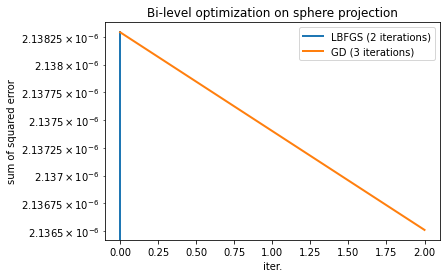

/students/u6361796/.conda/envs/myconda/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


NameError: name 'alpha_true' is not defined

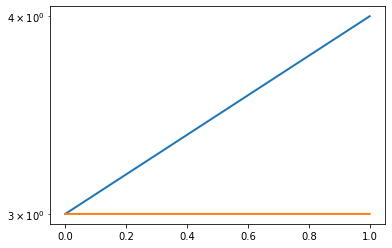

In [16]:

plt.figure()
plt.semilogy(history1, lw=2)
plt.semilogy(history2, lw=2)
plt.xlabel("iter."); plt.ylabel("sum of squared error")
plt.title("Bi-level optimization on sphere projection")
plt.legend(["LBFGS ({} iterations)".format(len(history1)),"GD ({} iterations)".format(len(history2))])
plt.show()

plt.figure()
plt.semilogy(alphas1, lw=2)
plt.semilogy(alphas2, lw=2)
plt.semilogy([alpha_true for i in range(len(alphas2))], lw=2,linestyle='dashed')
plt.xlabel("iter."); plt.ylabel("r")
plt.title("Bi-level optimization on sphere projection")
plt.legend(["LBFGS ({} iterations)".format(len(history1)),"GD ({} iterations)".format(len(history2)),'true r'])
plt.show()

#### On ball projection:

Similarly, We can do bi-level optimisation learning for ball projection

In [ ]:
# node = L1Sphere()
node = LInfSphere()
# node = L1Ball()

x_init = torch.as_tensor(np.random.rand(10))
r_init=torch.as_tensor(random.uniform(15, 20))
y_init,_ = node.project(x_init,r_init)

if train_x:
    x_true = torch.as_tensor(np.random.rand(10))
else:
    x_true = x_init.clone()
r_true=torch.as_tensor(random.uniform(1, 5))
y_target,_ = node.project(x_true,r_true)

train_x=False

In [ ]:

r_gd1, history1,rs1,ys1,x_final1 = lbfgs(node, y_target,max_iters=1000,x_init=x_init,theta_init=r_init,train_x=train_x)
r_gd2, history2,rs2,ys2,x_final2 = simpleGradientDescent(node, y_target,max_iters=1000,x_init=x_init,theta_init=r_init,step_size=0.5,train_x=train_x)

In [ ]:
print('x init:', x_init)
print('r init:',r_init)
print('y init:',y_init)
print("")
print('x true:',x_true)
print('r true:',r_true)
print('y true:',y_target)
print()
print('x final lbfg: ',x_final1)
print('x final simple gradient: ',x_final2)
print()
print('r final lbfg: ',r_gd1)
print('r final simple gradient: ',r_gd2)
print()
print('y final lbfg:',node.project(x_final1, r_gd1)[0])
print('y final simple gradient:',node.project(x_final2, r_gd2)[0])

In [ ]:
plt.figure()
plt.semilogy(history1, lw=2)
plt.semilogy(history2, lw=2)
plt.xlabel("iter."); plt.ylabel("sum of squared error")
plt.title("Bi-level optimization on sphere projection")
plt.legend(["LBFGS ({} iterations)".format(len(history1)),"GD ({} iterations)".format(len(history2))])
plt.show()

plt.figure()
plt.semilogy(rs1, lw=2)
plt.semilogy(rs2, lw=2)
plt.semilogy([r_true for i in range(len(rs2))], lw=2,linestyle='dashed')
plt.xlabel("iter."); plt.ylabel("r")
plt.title("Bi-level optimization on sphere projection")
plt.legend(["LBFGS ({} iterations)".format(len(history1)),"GD ({} iterations)".format(len(history2)),'true r'])
plt.show()